# 데이터 확인하기 

연관 자료 : https://monkeylearn.com/keyword-extraction/

- offerings.csv : 평가의 대상이 되는 호텔들 이름과 위치, 등급 
- reviews.csv : 리뷰 데이터셋

In [2]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_review = pd.read_csv('../dataset/240128_TripAdvisorHotelReviews/reviews.csv')
df_review.shape

(878561, 10)

In [4]:
df_hotel = pd.read_csv('../dataset/240128_TripAdvisorHotelReviews/offerings.csv')
df_hotel.shape

(4333, 9)

In [5]:
#값이 아예 없어서 삭제해주기 
df_hotel = df_hotel.drop(columns=['phone','details']) 
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hotel_class  3141 non-null   float64
 1   region_id    4333 non-null   int64  
 2   url          4333 non-null   object 
 3   address      4333 non-null   object 
 4   type         4333 non-null   object 
 5   id           4333 non-null   int64  
 6   name         4333 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 237.1+ KB


In [6]:
#'id'란 이름이 헷갈리므로 변경해주기 
df_review = df_review.rename(columns={'offering_id': 'hotel_id', 'id': 'user_id'})

In [8]:
# Assuming 'offering_id' in df_review corresponds to 'id' in df_hotel

#inner로 하면 nan이 없게 되고 left로 하면 호텔번호가 없는 행의 경우 nan이 생길수도 있음. 
df = pd.merge(df_review, df_hotel, left_on='hotel_id', right_on='id', how='inner')

# 'offering_id' column is duplicated in the merged DataFrame, you may want to drop one of them
df = df.drop(columns=['hotel_id'])


In [10]:
#str 형식에서 json형식으로 바꿔주기 
df['ratings'] = df['ratings'].apply(lambda x: json.loads(x.replace("'", "\"")) if isinstance(x, str) else x)

#replace를 통해 '' -> ""로 바꿔주기 
df['ratings'] = df['ratings'].apply(lambda x: {k.replace("'", "\""): v for k, v in x.items()})

#json_normalize를 통해 하나의 json을 각 컬럼으로 펼치기 
#TODO : NaN으로 채우기 
normalized_ratings = json_normalize(df['ratings'],meta = ['title','text','author','date_stayed','offering_id','num_helpful_votes','date','id','via_mobile'],errors = 'ignore')

#새로 만든 normalized_ratings의 칼럼들 이름을 ratings+ ___ 로 바꿔주기 
normalized_ratings.columns = ['ratings_' + col for col in normalized_ratings.columns]
normalized_ratings

ratings_service  ratings_cleanliness  ratings_overall  ratings_value  \
0                   5.0                  5.0              5.0            5.0   
1                   5.0                  5.0              5.0            5.0   
2                   5.0                  5.0              5.0            5.0   
3                   5.0                  5.0              5.0            4.0   
4                   5.0                  5.0              5.0            4.0   
...                 ...                  ...              ...            ...   
878556              5.0                  5.0              5.0            NaN   
878557              3.0                  3.0              3.0            NaN   
878558              NaN                  NaN              5.0            NaN   
878559              NaN                  NaN              5.0            NaN   
878560              NaN                  NaN              5.0            NaN   

        ratings_location  ratings_sleep_quality  ratings_rooms  \
0                    5.0                    5.0            5.0   
1                    5.0                    5.0            5.0   
2                    5.0                    5.0            5.0   
3                    5.0                    5.0            5.0   
4                    5.0                    5.0            5.0   
...                  ...                    ...            ...   
878556               NaN                    NaN            5.0   
878557               NaN                    NaN            3.0   
878558               NaN                    NaN            NaN   
878559               NaN                    NaN            NaN   
878560               NaN                    NaN            NaN   

        ratings_check_in_front_desk  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               NaN   
4                               NaN   
...                             ...   
878556                          NaN   
878557                          NaN   
878558                          NaN   
878559                          NaN   
878560                          NaN   

        ratings_business_service_(e_g_internet_access)  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
...                                                ...  
878556                                             NaN  
878557                                             NaN  
878558                                             NaN  
878559                                             NaN  
878560                                             NaN  

[878561 rows x 9 columns]

In [14]:
#ratings값 중에서 결측치 비율이 너무 높은 칼럼은 삭제하기
normalized_ratings = normalized_ratings.drop('ratings_check_in_front_desk', axis=1)
normalized_ratings = normalized_ratings.drop('ratings_business_service_(e_g_internet_access)', axis=1)
normalized_ratings.shape

(878561, 7)

### 기본 행 번호를 인덱스로 설정해주기 

In [15]:
print(df.index)
print(normalized_ratings.index)

RangeIndex(start=0, stop=878561, step=1)
RangeIndex(start=0, stop=878561, step=1)


### 새로 만든 normalized_ratings df와 원본 df를 열 방향으로 합치기 

In [16]:
df = pd.concat([df, normalized_ratings], axis=1)
df.shape

(878561, 23)

In [21]:
df.drop(columns=['ratings'], inplace=True)
df.shape

(878561, 22)

In [30]:
import json

def safe_json_loads(x):
    try:
        return json.loads(x.replace("'", "\"")) if isinstance(x, str) else x
    except json.JSONDecodeError:
        return x

df['address'] = df['address'].apply(safe_json_loads)


In [33]:
#json_normalize를 통해 하나의 json을 각 컬럼으로 펼치기 
#TODO : NaN으로 채우기 
normalized_address.columns = ['address_' + col for col in normalized_address.columns]


In [39]:
normalized_address.index

RangeIndex(start=0, stop=878561, step=1)

In [38]:
df.index

RangeIndex(start=0, stop=878561, step=1)

In [40]:
df = pd.concat([df, normalized_address], axis=1)
df.shape

(878561, 26)

In [48]:
# 주(State)를 기반으로 지역을 나누는 함수
def classify_region(state):
    east_coast = ['NY', 'MA', 'DC', 'PA', 'MD', 'NC', 'FL']
    west_coast = ['CA', 'WA']
    midwest = ['IL', 'IN', 'OH', 'MI']
    south = ['TX', 'TN']

    if state in east_coast:
        return 'East Coast'
    elif state in west_coast:
        return 'West Coast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    else:
        return 'Other'

# 'region' 칼럼을 추가하여 주(State)를 기반으로 지역을 나누기
df['address_region_category'] = df['address_region'].apply(classify_region)


In [52]:
df['address_postal-code'].value_counts()

address_postal-code
10036       54052
10019       47430
10001       30913
94102       27099
60611       27006
            ...  
77381           1
32250           1
60620           1
TX 75219        1
21223           1
Name: count, Length: 835, dtype: int64

### 영어가 아닌 다른 언어로 적힌 행들은 삭제해주기

In [53]:
import langid

# 언어 감지 함수
def detect_language(text):
    try:
        lang, _ = langid.classify(text)
        return lang
    except Exception as e:
        print(f"Error detecting language: {e}")
        return None

# 'text' 칼럼에서 언어 감지 후, 영어가 아닌 행 삭제
df['language'] = df['text'].apply(detect_language)

In [38]:
df['language'].value_counts()

language
en    7752
de     245
fr     240
it     202
es     138
ja      73
pt      37
nl      33
sv      21
no      19
da      16
zh       3
ca       1
se       1
nn       1
lt       1
nb       1
pl       1
ko       1
Name: count, dtype: int64

In [39]:
df = df[df['language'] == 'en']
df

ratings  \
0     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2     {'service': 2.0, 'cleanliness': 3.0, 'overall'...   
3     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
4     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
...                                                 ...   
8781  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
8782  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8783  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8784                                   {'overall': 5.0}   
8785  {'service': 1.0, 'cleanliness': 1.0, 'overall'...   

                                                  title  \
0     “Very nice experience for a country boy going ...   
1                                     “Great Courtyard”   
2                       “Location, location, location!”   
3     “This place is run down, not taken care of at ...   
4                     “The good, the bad and the ugly.”   
...                                                 ...   
8781                                “Fantastic Service”   
8782   “If you get the good rooms, the view is awesome”   
8783   “Super Hotel in New York - Real value for money”   
8784                          “Ultimate New York Hotel”   
8785                                            “AWFUL”   

                                                   text  \
0     Being from a small town in Tennessee, I was ve...   
1     I stayed at this courtyard for 2 nights . Ever...   
2     Even in Boston for $180 plus taxes per night y...   
3     This hotel is a great old building (formerly t...   
4     The Good~room was larger than expected, free i...   
...                                                 ...   
8781  We stayed at the Grand del Mar because my husb...   
8782  Firstly, I find that San Francisco hotels gene...   
8783  Rooms very clean and big for new york standard...   
8784  My wife and I spent an anniversary here last O...   
8785  Rooms dirty and small. No customer service. In...   

                                                 author     date_stayed  \
0     {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1     {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2     {'username': 'marknthedark', 'num_cities': 17,...  September 2007   
3     {'username': 'Largeandy', 'num_cities': 16, 'n...   February 2012   
4     {'username': 'bigdog717', 'num_cities': 2, 'nu...       July 2010   
...                                                 ...             ...   
8781  {'username': 'Ontario_Sun_lovers', 'num_cities...       June 2010   
8782  {'username': 'mark_mb', 'num_cities': 21, 'num...        May 2010   
8783  {'username': 'DenmarkTraveler', 'num_reviews':...   December 2009   
8784  {'username': 'Steven_Goldberg', 'num_reviews':...    October 2006   
8785  {'username': 'carengur', 'num_reviews': 1, 'id...      April 2009   

      offering_id  num_helpful_votes        date         id  via_mobile  ...  \
0          111492                  2  2010-10-25   84800976       False  ...   
1          108562                  0  2009-10-14   46861760       False  ...   
2           94354                  1  2007-10-20   10172355       False  ...   
3           98798                  2  2012-02-09  124329781       False  ...   
4           93889                  0  2010-07-06   69904714       False  ...   
...           ...                ...         ...        ...         ...  ...   
8781       781627                  0  2010-06-22   68326910       False  ...   
8782        81295                  1  2010-10-23   84568810       False  ...   
8783      1060157                  0  2010-02-09   55572710       False  ...   
8784       224224                  7  2007-09-11    8693338       False  ...   
8785        99288                  0  2009-08-08   37094987       False  ...   

      ratings_service  ratings_cleanliness  ratings_overall

In [40]:
df.drop(columns=['language'], inplace=True)
df.head(3)

/var/folders/v5/f_7vslxd3bj07chbkmd7nlkh0000gn/T/ipykernel_15178/1994195839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['language'], inplace=True)


ratings  \
0  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2  {'service': 2.0, 'cleanliness': 3.0, 'overall'...   

                                               title  \
0  “Very nice experience for a country boy going ...   
1                                  “Great Courtyard”   
2                    “Location, location, location!”   

                                                text  \
0  Being from a small town in Tennessee, I was ve...   
1  I stayed at this courtyard for 2 nights . Ever...   
2  Even in Boston for $180 plus taxes per night y...   

                                              author     date_stayed  \
0  {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1  {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2  {'username': 'marknthedark', 'num_cities': 17,...  September 2007   

   offering_id  num_helpful_votes        date        id  via_mobile  index  \
0       111492                  2  2010-10-25  84800976       False      0   
1       108562                  0  2009-10-14  46861760       False      1   
2        94354                  1  2007-10-20  10172355       False      2   

   ratings_service  ratings_cleanliness  ratings_overall  ratings_value  \
0              5.0                  5.0              5.0            4.0   
1              5.0                  5.0              4.0            5.0   
2              2.0                  3.0              3.0            3.0   

   ratings_location  ratings_sleep_quality  ratings_rooms  \
0               5.0                    5.0            4.0   
1               5.0                    NaN            5.0   
2               5.0                    NaN            2.0   

   ratings_check_in_front_desk  ratings_business_service_(e_g_internet_access)  
0                          NaN                                             NaN  
1                          NaN                                             NaN  
2                          2.0                                             NaN

In [42]:
df.shape

(7752, 20)

### 전체 title 칼럼 word cloud로 그려보기

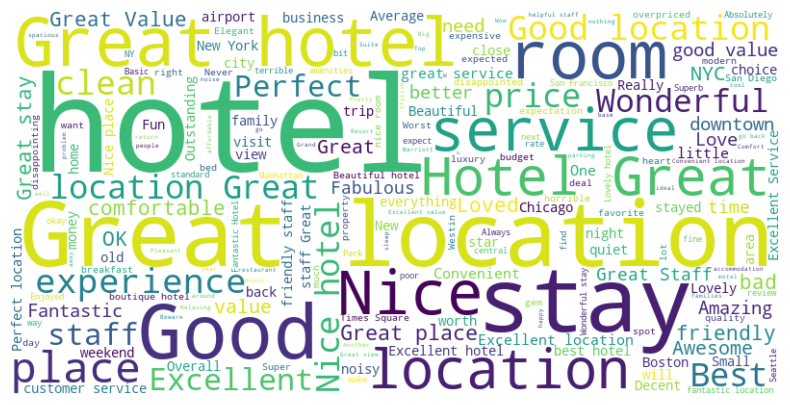

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 모든 제목을 하나의 문자열로 결합
all_titles = ' '.join(df['title'].astype(str))

# Word Cloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### ratings_overall 점수에 따라 word cloud 그려보기

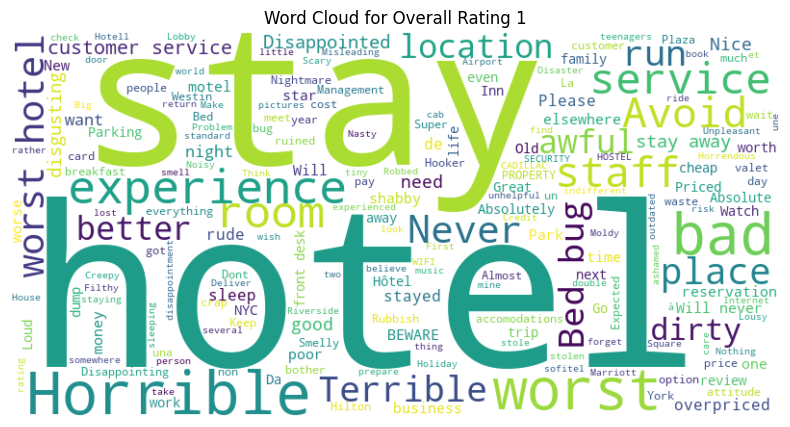

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 만족도가 1점인 데이터 추출
titles_1 = ' '.join(df[df['ratings_overall'] == 1]['title'].astype(str))

# Word Cloud 생성
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(titles_1)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for Overall Rating 1')
plt.axis('off')
plt.show()


### word cloud보다는 상위 10개 단어만 추출해서 비교해보기 

In [138]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/songye/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [44]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# NLTK의 불용어 다운로드
import nltk
nltk.download('stopwords')

# 불용어 설정
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# 만족도가 1점인 데이터 추출
titles_1 = ' '.join(df[df['ratings_overall'] == 1]['title'].astype(str))

# 불용어 제외하고 자주 등장하는 단어 확인
tokens_1 = word_tokenize(titles_1)
filtered_tokens_1 = [word.lower() for word in tokens_1 if word.isalpha() and word.lower() not in stop_words]

# 자주 등장하는 단어 확인
word_freq_1 = Counter(filtered_tokens_1)
print(word_freq_1.most_common(10))

[('hotel', 70), ('stay', 65), ('worst', 40), ('service', 30), ('ever', 27), ('bad', 25), ('horrible', 24), ('experience', 22), ('never', 21), ('staff', 18)]


In [46]:
# 기존 불용어에 추가할 사용자 정의 불용어 리스트
custom_stop_words = ['hotel']

# 기존 불용어에 사용자 정의 불용어 추가
stop_words = set(stopwords.words('english') + custom_stop_words)

In [47]:
# 만족도별로 자주 등장하는 단어 확인하는 함수
def frequent_words_by_rating(rating):
    # 해당 만족도의 데이터 추출
    titles_by_rating = ' '.join(df[df['ratings_overall'] == rating]['title'].astype(str))

    # 토큰화 및 불용어 제거
    tokens = word_tokenize(titles_by_rating)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # 자주 등장하는 단어 확인
    word_freq = Counter(filtered_tokens)

    # 가장 자주 등장하는 단어 10개 출력
    print(f'Most frequent words for Overall Rating {rating}:')
    print(word_freq.most_common(10))
    print()

# 각 만족도별로 자주 등장하는 단어 확인
for rating in range(1, 6):
    frequent_words_by_rating(rating)


Most frequent words for Overall Rating 1:
[('stay', 65), ('worst', 40), ('service', 30), ('ever', 27), ('bad', 25), ('horrible', 24), ('experience', 22), ('never', 21), ('staff', 18), ('avoid', 16)]

Most frequent words for Overall Rating 2:
[('stay', 43), ('great', 37), ('location', 36), ('service', 36), ('good', 30), ('poor', 26), ('room', 24), ('staff', 20), ('bad', 19), ('disappointed', 18)]

Most frequent words for Overall Rating 3:
[('location', 217), ('good', 162), ('great', 157), ('ok', 71), ('nice', 69), ('stay', 49), ('rooms', 44), ('average', 43), ('room', 42), ('bad', 42)]

Most frequent words for Overall Rating 4:
[('great', 767), ('location', 609), ('good', 385), ('nice', 302), ('stay', 268), ('value', 135), ('place', 130), ('staff', 101), ('service', 100), ('clean', 95)]

Most frequent words for Overall Rating 5:
[('great', 1018), ('location', 463), ('stay', 385), ('excellent', 248), ('service', 213), ('place', 191), ('staff', 181), ('wonderful', 163), ('best', 151), ('n

### 제목에 location이 들어간 사람들의 ratings 확인하기
워낙 overall 점수 자체가 높기 때문에 어떤 상관관계를 확인하기는 힘들다. 

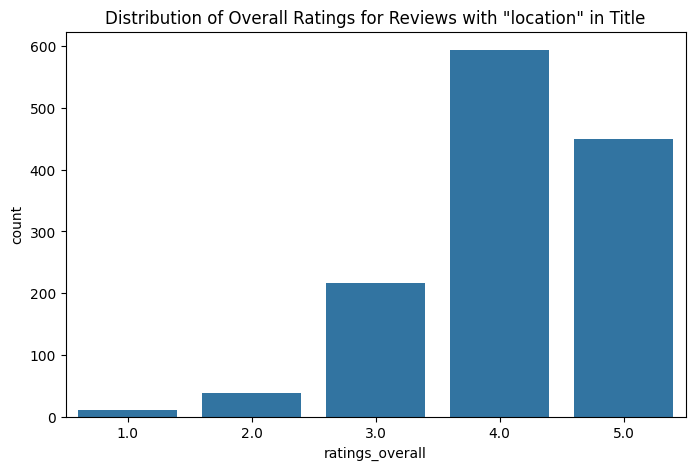

In [48]:
# 'title'에 'location'이 포함된 리뷰 추출
location_reviews = df[df['title'].str.contains('location', case=False, na=False)]

# 'ratings_overall'의 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x='ratings_overall', data=location_reviews)
plt.title('Distribution of Overall Ratings for Reviews with "location" in Title')
plt.show()


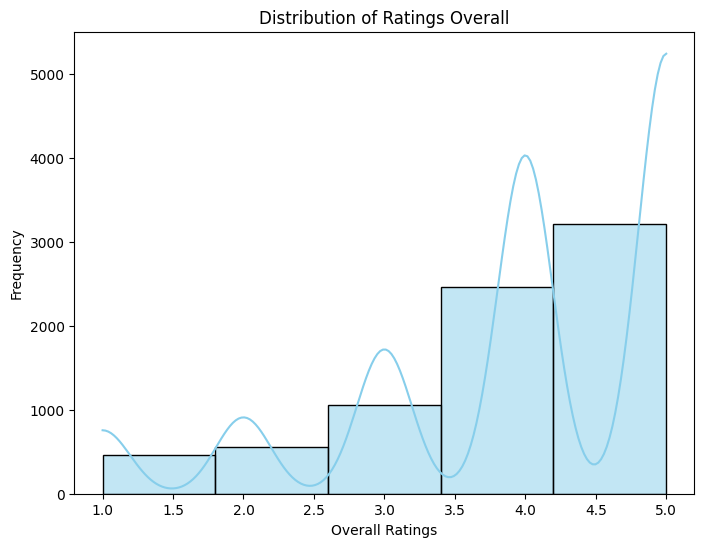

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# ratings_overall에 해당하는 분포를 시각화
plt.figure(figsize=(8, 6))
sns.histplot(df['ratings_overall'], bins=5, kde=True, color='skyblue')
plt.title('Distribution of Ratings Overall')
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.show()


In [203]:
from scipy.stats import ttest_ind

# Location 키워드를 포함한 그룹
group_location = df[df['title'].str.contains('location', case=False)]['ratings_overall']

# Location 키워드를 포함하지 않은 그룹
group_no_location = df[~df['title'].str.contains('location', case=False)]['ratings_overall']

# t-검정 수행
t_statistic, p_value = ttest_ind(group_location, group_no_location, equal_var=False)

# 결과 출력
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

#TODO : t-검정 살펴보기 


T-Statistic: 6.468979111706569
P-Value: 1.1922656538797675e-10


### 그냥 빈도수 높은 어휘가 아니라 빈도수 높은 감정 어휘만을 뽑아볼 수는 없을까?

In [50]:
import nltk
from nltk.corpus import opinion_lexicon

# NLTK 데이터 다운로드
nltk.download('opinion_lexicon')
nltk.download('punkt')

# 감정 어휘 로드
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/songye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
# 감정 분석 함수
def analyze_sentiment(text):
    tokens = word_tokenize(text.lower())
    positive = [word for word in tokens if word in positive_words]
    negative = [word for word in tokens if word in negative_words]
    sentiment = 'positive' if len(positive) > len(negative) else 'negative' if len(negative) > len(positive) else 'neutral'
    return {
        'positive_words': positive,
        'negative_words': negative,
        'sentiment': sentiment
    }

# ratings_overall 점수에 따라 title 분류 및 감정어휘 추출
ratings = df['ratings_overall'].unique()

for rating in ratings:
    # 특정 점수에 해당하는 데이터 추출
    subset_df = df[df['ratings_overall'] == rating]
    
    # 해당 데이터의 title에 대해 감정어휘 추출
    all_positive_words = []
    all_negative_words = []
    for title in subset_df['title'].astype(str):
        result = analyze_sentiment(title)
        all_positive_words.extend(result['positive_words'])
        all_negative_words.extend(result['negative_words'])
    
    # 가장 많이 등장한 긍정어휘 및 부정어휘 10개 추출
    top_positive_words = [word for word, count in Counter(all_positive_words).most_common(3)]
    top_negative_words = [word for word, count in Counter(all_negative_words).most_common(3)]
    
    # 결과 출력
    print(f"Sentiment Analysis for Overall Rating {rating}:")
    print(f"Top 10 Positive Words: {top_positive_words}")
    print(f"Top 10 Negative Words: {top_negative_words}")
    print("\n")

    #TODO : 감정어휘 빈도별로 살펴보기 


Sentiment Analysis for Overall Rating 5.0:
Top 10 Positive Words: ['great', 'excellent', 'wonderful']
Top 10 Negative Words: ['break', 'complaints', 'bad']


Sentiment Analysis for Overall Rating 4.0:
Top 10 Positive Words: ['great', 'good', 'nice']
Top 10 Negative Words: ['bad', 'expensive', 'noisy']


Sentiment Analysis for Overall Rating 3.0:
Top 10 Positive Words: ['good', 'great', 'nice']
Top 10 Negative Words: ['bad', 'noisy', 'expensive']


Sentiment Analysis for Overall Rating 2.0:
Top 10 Positive Words: ['great', 'good', 'nice']
Top 10 Negative Words: ['poor', 'bad', 'disappointed']


Sentiment Analysis for Overall Rating 1.0:
Top 10 Positive Words: ['better', 'nice', 'like']
Top 10 Negative Words: ['worst', 'bad', 'horrible']




In [53]:
from collections import Counter

# 각 등급(점수)별로 단어의 출현 빈도를 저장할 딕셔너리 생성
word_frequencies = {
    '5.0': Counter(),
    '4.0': Counter(),
    '3.0': Counter(),
    '2.0': Counter(),
    '1.0': Counter()
}

# 각 등급(점수)별로 title에서 해당 단어가 몇 번 나왔는지 계산
for score in ['5.0', '4.0', '3.0', '2.0', '1.0']:
    positive_words = ['great', 'excellent', 'wonderful', 'good', 'nice', 'like', 'better']
    negative_words = ['break', 'complaints', 'bad', 'expensive', 'noisy', 'poor', 'disappointed', 'worst', 'horrible']
    
    # Positive Words
    for word in positive_words:
        word_frequencies[score][f'Positive_{word}'] = df[(df['ratings_overall'] == float(score)) & (df['title'].str.contains(word, case=False))].shape[0]
    
    # Negative Words
    for word in negative_words:
        word_frequencies[score][f'Negative_{word}'] = df[(df['ratings_overall'] == float(score)) & (df['title'].str.contains(word, case=False))].shape[0]

# 결과 출력
for score, frequencies in word_frequencies.items():
    print(f"Sentiment Analysis for Overall Rating {score}:")
    print(f"Top 10 Positive Words: {sorted([(word, freq) for word, freq in frequencies.items() if 'Positive_' in word], key=lambda x: x[1], reverse=True)[:10]}")
    print(f"Top 10 Negative Words: {sorted([(word, freq) for word, freq in frequencies.items() if 'Negative_' in word], key=lambda x: x[1], reverse=True)[:10]}\n")


Sentiment Analysis for Overall Rating 5.0:
Top 10 Positive Words: [('Positive_great', 891), ('Positive_excellent', 249), ('Positive_wonderful', 159), ('Positive_nice', 135), ('Positive_good', 90), ('Positive_like', 34), ('Positive_better', 23)]
Top 10 Negative Words: [('Negative_break', 16), ('Negative_expensive', 7), ('Negative_complaints', 5), ('Negative_bad', 5), ('Negative_poor', 1), ('Negative_disappointed', 1), ('Negative_noisy', 0), ('Negative_worst', 0), ('Negative_horrible', 0)]

Sentiment Analysis for Overall Rating 4.0:
Top 10 Positive Words: [('Positive_great', 696), ('Positive_good', 364), ('Positive_nice', 306), ('Positive_excellent', 91), ('Positive_wonderful', 35), ('Positive_like', 18), ('Positive_better', 17)]
Top 10 Negative Words: [('Negative_break', 23), ('Negative_bad', 21), ('Negative_expensive', 16), ('Negative_noisy', 9), ('Negative_complaints', 8), ('Negative_poor', 2), ('Negative_disappointed', 1), ('Negative_horrible', 1), ('Negative_worst', 0)]

Sentiment A

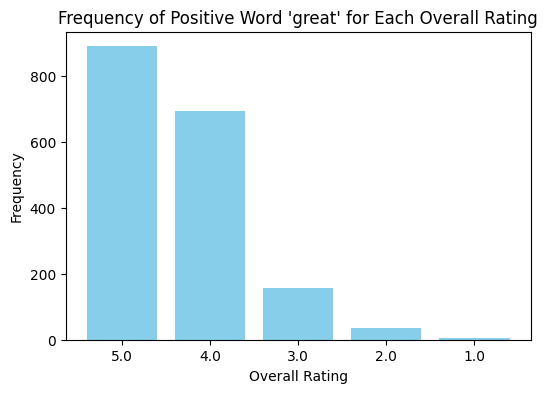

In [55]:
import matplotlib.pyplot as plt

# 각 등급(점수)별로 'great'의 긍정 단어 빈도를 저장할 리스트 생성
positive_great_frequencies = [word_frequencies[score]['Positive_great'] for score in ['5.0', '4.0', '3.0', '2.0', '1.0']]

# 막대 그래프 그리기
plt.figure(figsize=(6, 4))
plt.bar(['5.0', '4.0', '3.0', '2.0', '1.0'], positive_great_frequencies, color='skyblue')
plt.title("Frequency of Positive Word 'great' for Each Overall Rating")
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.show()


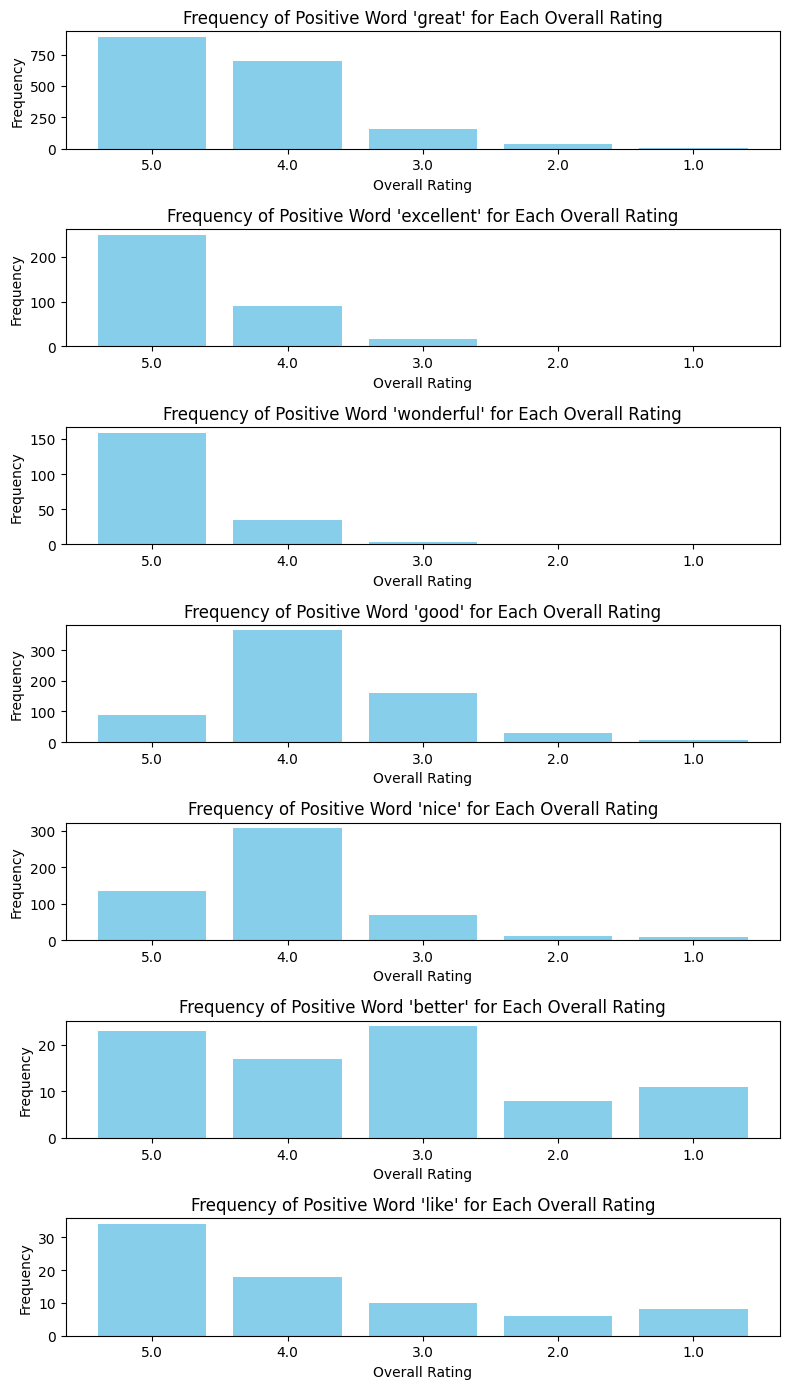

In [61]:
# 긍정 단어 나누기
positive_words = ['great', 'excellent', 'wonderful', 'good', 'nice', 'better', 'like']

# 모든 단어에 대한 빈도 데이터 초기화
word_frequencies = {word: {'Positive': []} for word in positive_words}

# 각 단어에 대해 긍정 빈도 수집
for word in positive_words:
    for score in ['5.0', '4.0', '3.0', '2.0', '1.0']:
        positive_frequency = df[(df['ratings_overall'] == float(score)) & (df['title'].str.contains(word, case=False, na=False))].shape[0]
        word_frequencies[word]['Positive'].append(positive_frequency)

# 막대 그래프 그리기
fig, axes = plt.subplots(nrows=len(positive_words), ncols=1, figsize=(8, 2 * len(positive_words)))

for i, word in enumerate(positive_words):
    # 긍정 단어의 빈도
    axes[i].bar(['5.0', '4.0', '3.0', '2.0', '1.0'], word_frequencies[word]['Positive'], color='skyblue')
    axes[i].set_title(f"Frequency of Positive Word '{word}' for Each Overall Rating")
    axes[i].set_xlabel("Overall Rating")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


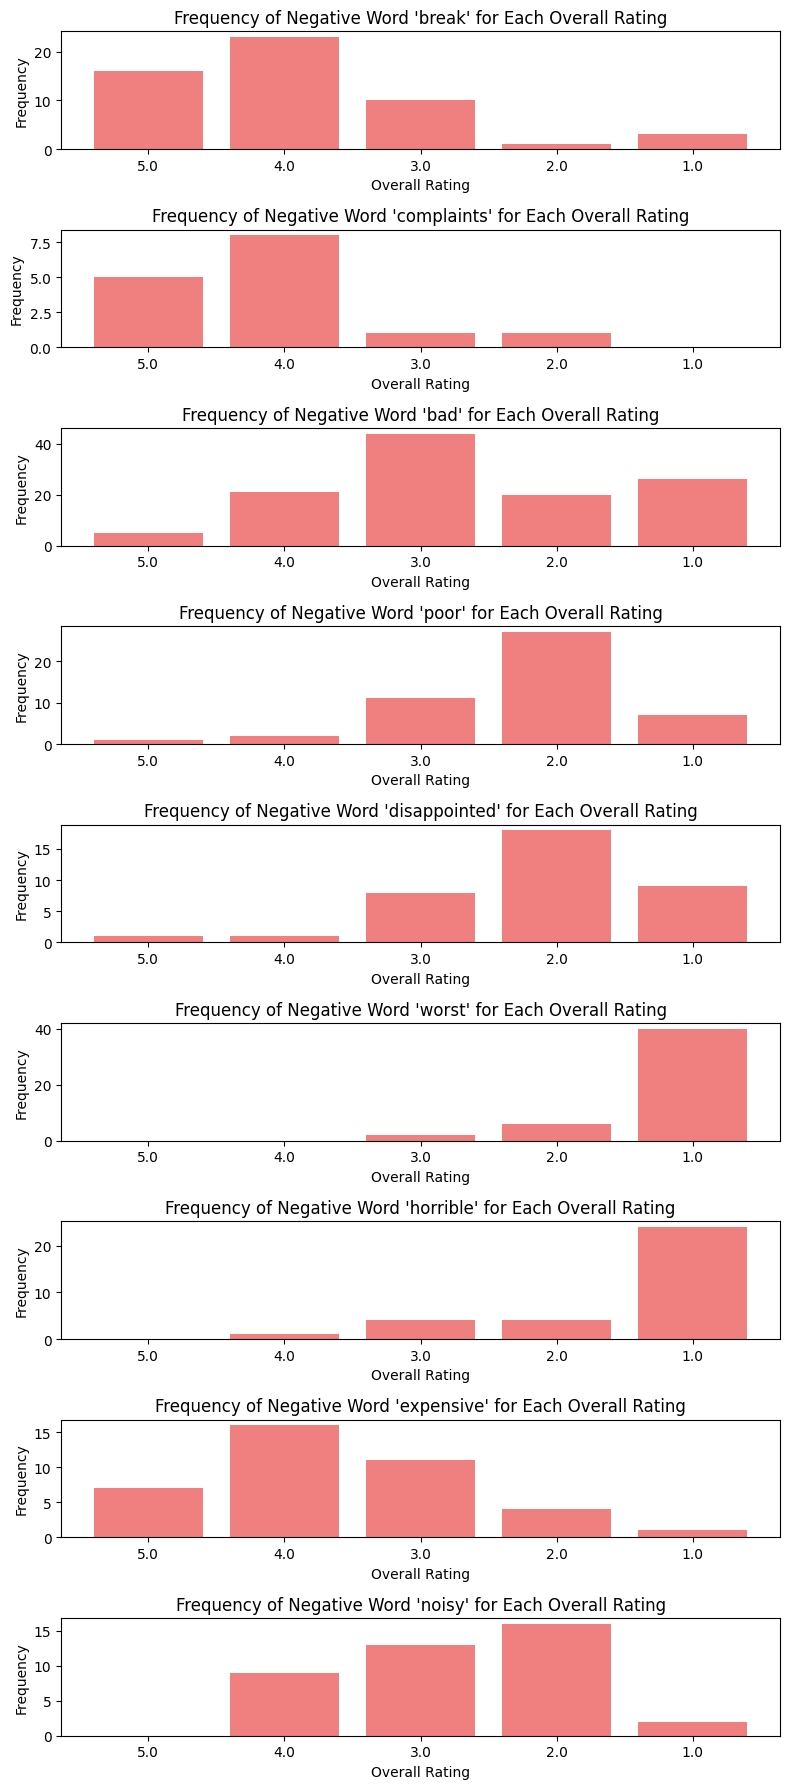

In [63]:
# 부정 단어 나누기
negative_words = ['break', 'complaints', 'bad', 'poor', 'disappointed', 'worst', 'horrible', 'expensive', 'noisy']

# 모든 단어에 대한 빈도 데이터 초기화
word_frequencies = {word: {'Negative': []} for word in negative_words}

# 각 단어에 대해 부정 빈도 수집
for word in negative_words:
    for score in ['5.0', '4.0', '3.0', '2.0', '1.0']:
        negative_frequency = df[(df['ratings_overall'] == float(score)) & (df['title'].str.contains(word, case=False, na=False))].shape[0]
        word_frequencies[word]['Negative'].append(negative_frequency)

# 막대 그래프 그리기
fig, axes = plt.subplots(nrows=len(negative_words), ncols=1, figsize=(8, 2 * len(negative_words)))

for i, word in enumerate(negative_words):
    # 부정 단어의 빈도
    axes[i].bar(['5.0', '4.0', '3.0', '2.0', '1.0'], word_frequencies[word]['Negative'], color='lightcoral')
    axes[i].set_title(f"Frequency of Negative Word '{word}' for Each Overall Rating")
    axes[i].set_xlabel("Overall Rating")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# text 칼럼 처리하기 

/var/folders/v5/f_7vslxd3bj07chbkmd7nlkh0000gn/T/ipykernel_15178/3457635930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


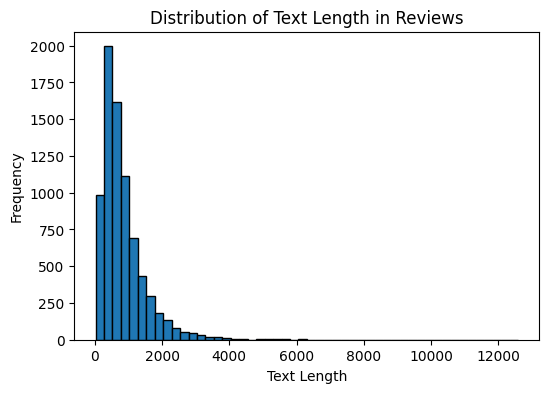

In [64]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 히스토그램으로 시각화
plt.figure(figsize=(6, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.title('Distribution of Text Length in Reviews')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


/var/folders/v5/f_7vslxd3bj07chbkmd7nlkh0000gn/T/ipykernel_15178/2035044283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


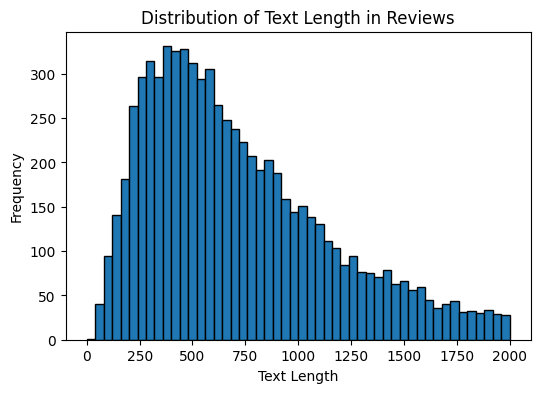

In [65]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 히스토그램으로 시각화 (중심 조절)
plt.figure(figsize=(6, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black', range=(0, 2000))  # 범위를 조절하여 원하는 중심으로 이동
plt.title('Distribution of Text Length in Reviews')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


/var/folders/v5/f_7vslxd3bj07chbkmd7nlkh0000gn/T/ipykernel_15178/1782059327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


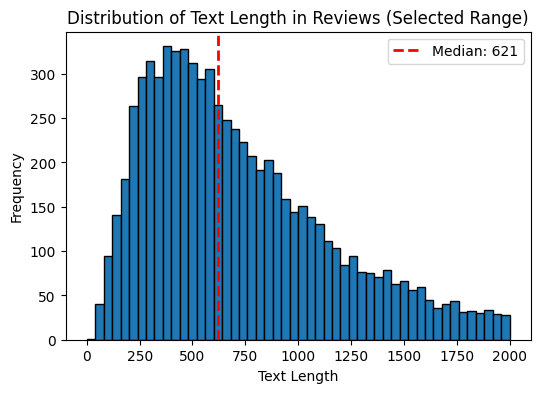

Median Text Length in the Selected Range: 621


In [66]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 주어진 범위 내의 데이터만 선택
range_start = 0
range_end = 2000
selected_data = df[(df['text_length'] >= range_start) & (df['text_length'] <= range_end)]

# 중앙값 계산
median_text_length = selected_data['text_length'].median()

# 히스토그램으로 시각화 (중심 조절)
plt.figure(figsize=(6, 4))
plt.hist(selected_data['text_length'], bins=50, edgecolor='black', range=(range_start, range_end))
plt.title('Distribution of Text Length in Reviews (Selected Range)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.axvline(median_text_length, color='red', linestyle='dashed', linewidth=2, label=f'Median: {int(median_text_length)}')
plt.legend()
plt.show()

# 중앙값 출력
print(f"Median Text Length in the Selected Range: {int(median_text_length)}")


### text의 길이와 num_helpful_votes는 어떤 관계가 있을까?
- 0.1에서 0.3: 약한 상관관계를 보인다.

/var/folders/v5/f_7vslxd3bj07chbkmd7nlkh0000gn/T/ipykernel_15178/172609539.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


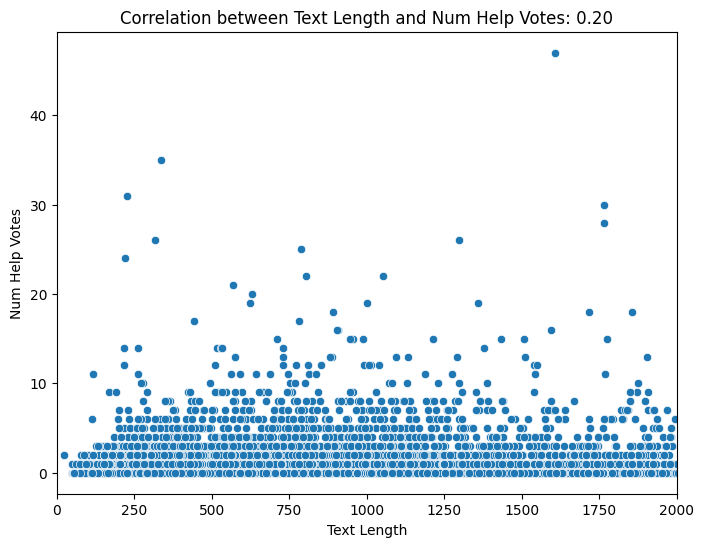

Correlation between Text Length and Num Help Votes: 0.20


In [67]:
import numpy as np
import seaborn as sns

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 상관관계 계산
correlation = np.corrcoef(df['text_length'], df['num_helpful_votes'])[0, 1]

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x='text_length', y='num_helpful_votes', data=df)
plt.title(f'Correlation between Text Length and Num Help Votes: {correlation:.2f}')
plt.xlabel('Text Length')
plt.ylabel('Num Help Votes')
plt.xlim(0, 2000)  # x 축 범위 설정
plt.show()

# 상관관계 출력
print(f'Correlation between Text Length and Num Help Votes: {correlation:.2f}')


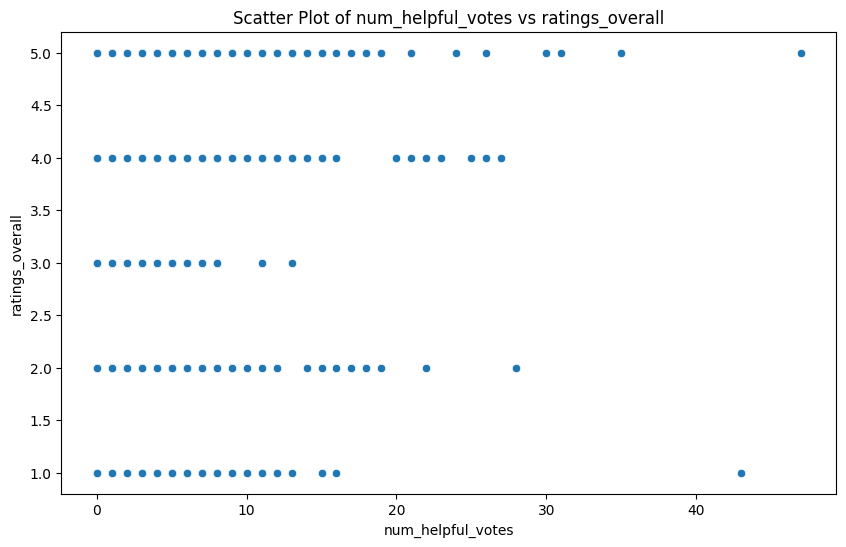

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_helpful_votes', y='ratings_overall', data=df)
plt.title('Scatter Plot of num_helpful_votes vs ratings_overall')
plt.xlabel('num_helpful_votes')
plt.ylabel('ratings_overall')
plt.show()


### 프랑스어로 적힌 리뷰글 시각화하기

In [69]:
from langdetect import detect
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼에 대해 언어 감지
df['language'] = df['text'].apply(lambda x: detect(x) if type(x) == str else None)

# 언어별 카운트
lang_counts = df['language'].value_counts()

# 영어, 프랑스어, 그 외의 언어로 구분
english_count = lang_counts.get('en', 0)
french_count = lang_counts.get('fr', 0)
other_count = df.shape[0] - english_count - french_count

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(['English', 'French', 'Other Languages'], [english_count, french_count, other_count], color=['blue', 'orange', 'green'])
plt.title('Number of Reviews by Language')
plt.ylabel('Number of Reviews')
plt.show()

# 결과 출력
print(f"Number of reviews in English: {english_count}")
print(f"Number of reviews in French: {french_count}")
print(f"Number of reviews in other languages: {other_count}")


KeyboardInterrupt: 

# ratings_overall 점수에 따른 텍스트 word cloud 만들기

#TODO : 명사, 어근, 형용사 위주로 찾아보기 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


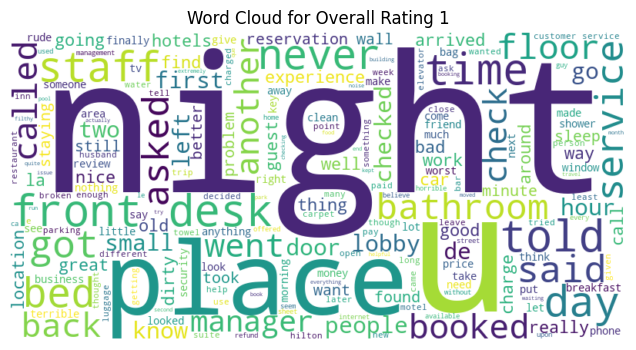

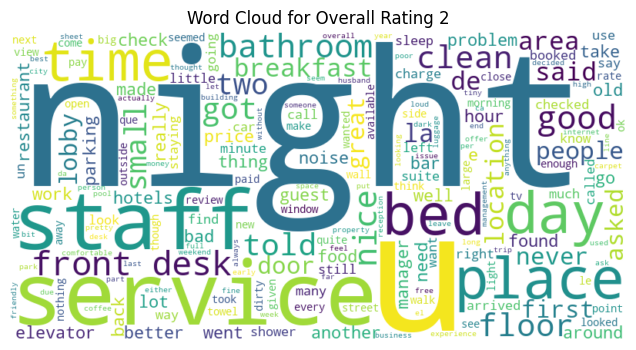

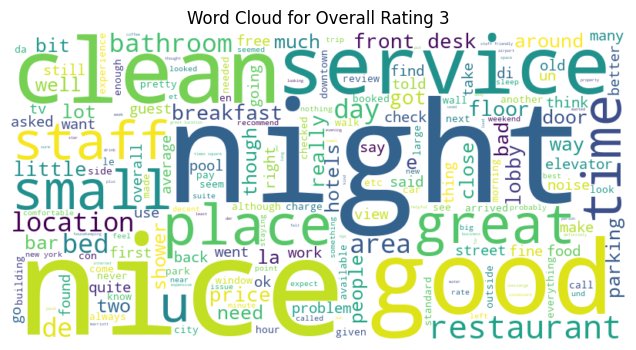

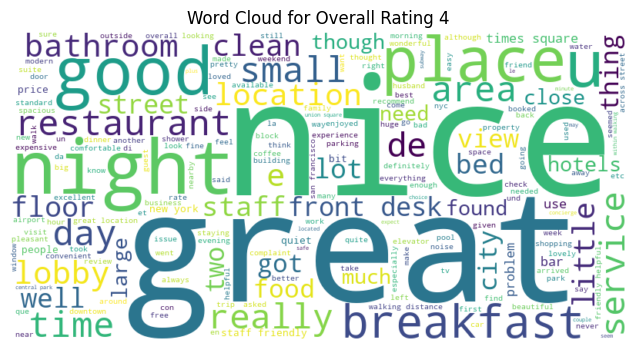

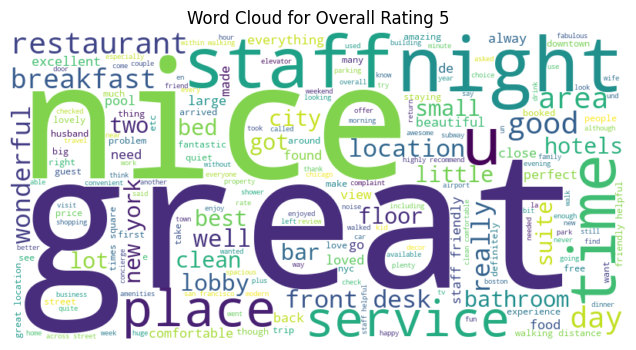

In [192]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk의 불용어 다운로드
import nltk
nltk.download('stopwords')

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)

additional_stop_words = ['hotel', 'stay', 'would', 'could', 'even', 'one','stay','stayed','room','rooms']

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)
stop_words = set(stopwords.words('english') + additional_stop_words)

# ratings_overall 값에 따른 Word Cloud 생성 함수
def generate_wordcloud_for_rating(rating, text_column):
    # 해당 rating에 해당하는 리뷰들 선택
    subset = df[df['ratings_overall'] == rating]
    
    # 해당 리뷰들의 text 컬럼을 합치기
    text = ' '.join(subset[text_column].astype(str))
    
    # 불용어 제거 및 토큰화
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    
    # Word Cloud 생성
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))
    
    # 시각화
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Overall Rating {rating}')
    plt.show()

# ratings_overall 값에 따라 Word Cloud 생성
for rating in range(1, 6):
    generate_wordcloud_for_rating(rating, 'text')


In [77]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [78]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

# ratings 값에 따라 데이터를 분할
ratings_categories = df['ratings_overall'].unique()

for rating_category in ratings_categories:
    # 특정 ratings에 해당하는 텍스트 추출
    texts_for_rating = df[df['ratings_overall'] == rating_category]['text']
    
    # 텍스트를 하나의 문자열로 결합
    combined_text = ' '.join(texts_for_rating)
    
    # 문자열을 토큰화하고 품사 태깅
    tokens = word_tokenize(combined_text)
    pos_tags = pos_tag(tokens)
    
    # 명사, 동사, 형용사 추출
    nouns = [word for word, pos in pos_tags if pos.startswith('N')]
    verbs = [word for word, pos in pos_tags if pos.startswith('V')]
    adjectives = [word for word, pos in pos_tags if pos.startswith('J')]
    
    # 빈도가 가장 높은 10개의 명사, 동사, 형용사 출력
    nouns_counter = Counter(nouns)
    verbs_counter = Counter(verbs)
    adjectives_counter = Counter(adjectives)
    
    top_nouns = nouns_counter.most_common(10)
    top_verbs = verbs_counter.most_common(10)
    top_adjectives = adjectives_counter.most_common(10)
    
    print(f"Ratings {rating_category} - Top 10 Nouns:", top_nouns)
    print(f"Ratings {rating_category} - Top 10 Verbs:", top_verbs)
    print(f"Ratings {rating_category} - Top 10 Adjectives:", top_adjectives)
    print("\n")


Ratings 5.0 - Top 10 Nouns: [('hotel', 5059), ('room', 3679), ('staff', 2238), ('location', 1371), ('rooms', 1261), ('service', 1119), ('stay', 1046), ('time', 968), ('night', 928), ('breakfast', 887)]
Ratings 5.0 - Top 10 Verbs: [('was', 9233), ('is', 5790), ('were', 3369), ('had', 2458), ('are', 2149), ('have', 2082), ('be', 1362), ('stayed', 1283), ('stay', 1208), ('did', 937)]
Ratings 5.0 - Top 10 Adjectives: [('great', 2428), ('nice', 1261), ('clean', 1173), ('good', 1061), ('comfortable', 973), ('helpful', 880), ('friendly', 875), ('free', 613), ('other', 559), ('excellent', 539)]


Ratings 4.0 - Top 10 Nouns: [('hotel', 4228), ('room', 3569), ('staff', 1385), ('location', 1232), ('rooms', 1142), ('breakfast', 894), ('night', 838), ('area', 756), ('service', 749), ('time', 706)]
Ratings 4.0 - Top 10 Verbs: [('was', 8530), ('is', 5367), ('were', 2842), ('had', 2032), ('are', 1997), ('have', 1652), ('be', 1246), ('did', 1013), ('stay', 914), ('stayed', 904)]
Ratings 4.0 - Top 10 Ad

In [81]:
# Define the keyword
keyword = 'staff'

# Iterate over each rating
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    # Count the number of rows where ratings_overall matches the current rating and the text contains the keyword
    positive_count = df[(df['ratings_overall'] == rating) & (df['text'].str.contains(keyword, case=False))].shape[0]
    
    # Count the total number of rows where ratings_overall matches the current rating
    total_count = df[df['ratings_overall'] == rating].shape[0]
    
    # Calculate the ratio
    positive_ratio = positive_count / total_count if total_count > 0 else 0
    
    print(f"The ratio of '{keyword}' mentions among ratings_overall=={rating} reviews is: {positive_ratio:.2%}")


The ratio of 'staff' mentions among ratings_overall==1.0 reviews is: 32.83%
The ratio of 'staff' mentions among ratings_overall==2.0 reviews is: 37.34%
The ratio of 'staff' mentions among ratings_overall==3.0 reviews is: 42.26%
The ratio of 'staff' mentions among ratings_overall==4.0 reviews is: 50.79%
The ratio of 'staff' mentions among ratings_overall==5.0 reviews is: 60.00%


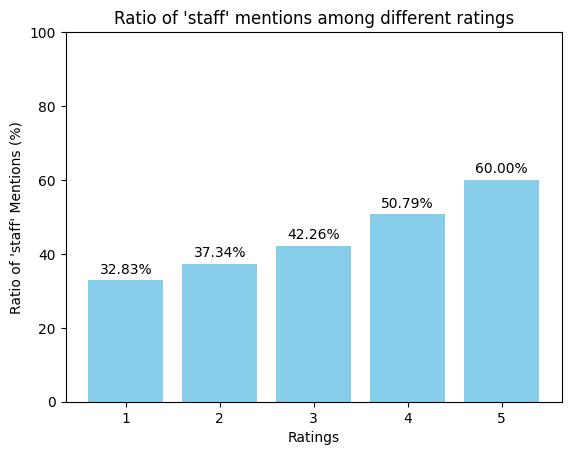

In [82]:
import matplotlib.pyplot as plt

# Define the keyword
keyword = 'staff'

# Lists to store ratings and corresponding ratios
ratings = []
ratios = []

# Iterate over each rating
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    # Count the number of rows where ratings_overall matches the current rating and the text contains the keyword
    positive_count = df[(df['ratings_overall'] == rating) & (df['text'].str.contains(keyword, case=False))].shape[0]
    
    # Count the total number of rows where ratings_overall matches the current rating
    total_count = df[df['ratings_overall'] == rating].shape[0]
    
    # Calculate the ratio
    positive_ratio = positive_count / total_count * 100 if total_count > 0 else 0
    
    # Append to lists
    ratings.append(rating)
    ratios.append(positive_ratio)

# Plotting the bar graph
plt.bar(ratings, ratios, color='skyblue')
plt.xlabel('Ratings')
plt.ylabel(f"Ratio of '{keyword}' Mentions (%)")
plt.title(f"Ratio of '{keyword}' mentions among different ratings")
plt.ylim(0, 100)  # Set the y-axis limit to ensure a proper scale

# Display the percentages on top of the bars
for i, ratio in enumerate(ratios):
    plt.text(ratings[i], ratio + 1, f'{ratio:.2f}%', ha='center', va='bottom')

plt.show()


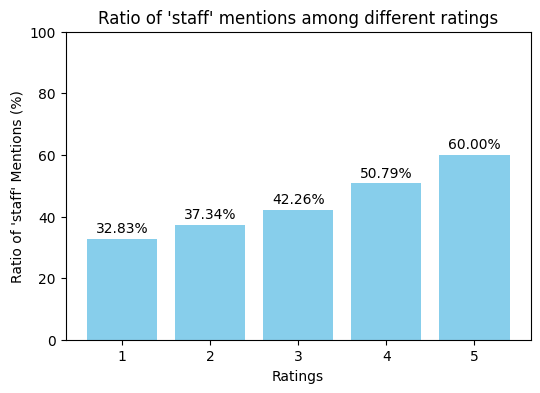

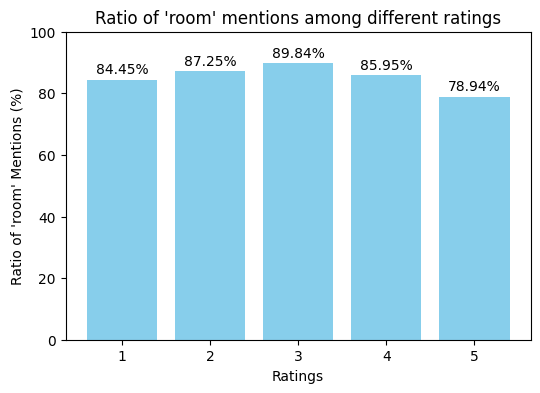

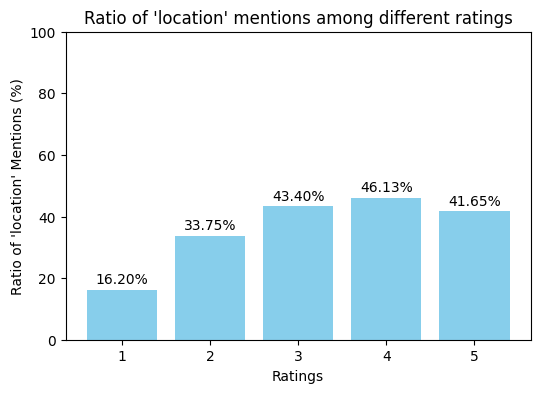

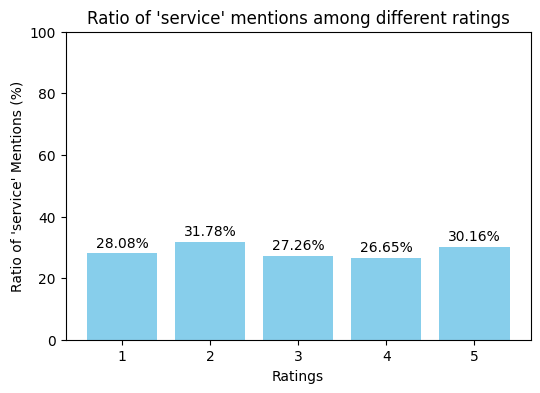

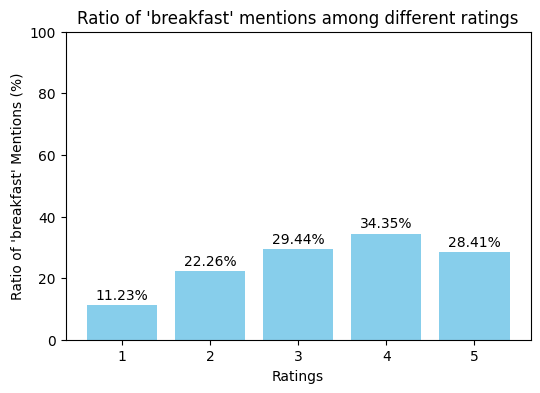

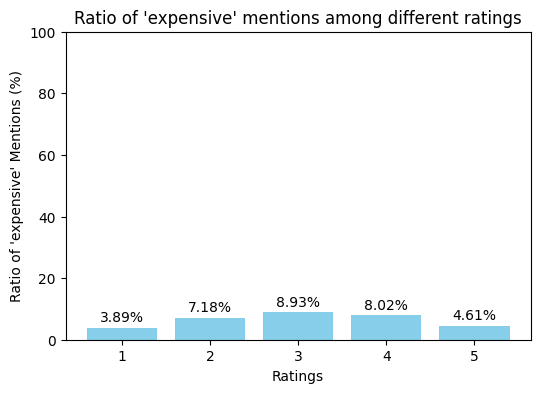

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame (replace this with your actual DataFrame)
# df = ...

# Define multiple keywords
keywords = ['staff', 'room', 'location', 'service','breakfast','expensive']

# Lists to store ratings and corresponding ratios for each keyword
ratings = {keyword: [] for keyword in keywords}
ratios = {keyword: [] for keyword in keywords}

# Iterate over each rating
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    # Iterate over each keyword
    for keyword in keywords:
        # Count the number of rows where ratings_overall matches the current rating and the text contains the keyword
        positive_count = df[(df['ratings_overall'] == rating) & (df['text'].str.contains(keyword, case=False))].shape[0]
        
        # Count the total number of rows where ratings_overall matches the current rating
        total_count = df[df['ratings_overall'] == rating].shape[0]
        
        # Calculate the ratio
        positive_ratio = positive_count / total_count * 100 if total_count > 0 else 0
        
        # Append to lists
        ratings[keyword].append(rating)
        ratios[keyword].append(positive_ratio)

# Plotting the bar graph for each keyword
for keyword in keywords:
    plt.figure(figsize=(6, 4))
    plt.bar(ratings[keyword], ratios[keyword], color='skyblue')
    plt.xlabel('Ratings')
    plt.ylabel(f"Ratio of '{keyword}' Mentions (%)")
    plt.title(f"Ratio of '{keyword}' mentions among different ratings")
    plt.ylim(0, 100)  # Set the y-axis limit to ensure a proper scale

    # Display the percentages on top of the bars
    for i, ratio in enumerate(ratios[keyword]):
        plt.text(ratings[keyword][i], ratio + 1, f'{ratio:.2f}%', ha='center', va='bottom')

    plt.show()


### 토픽 모델링

In [88]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS

# Assuming df is your DataFrame

# Define the unique ratings_overall scores
unique_ratings = df['ratings_overall'].unique()

# Iterate over each unique rating
for rating in unique_ratings:
    # Filter the DataFrame for the specific rating
    rating_df = df[df['ratings_overall'] == rating]
    
    # Preprocess the text data for the specific rating
    texts = rating_df['text'].astype(str).values.tolist()

    # Remove stopwords and tokenize
    stop_words = set(STOPWORDS)
    tokenized_texts = [[word for word in text.lower().split() if word not in stop_words] for text in texts]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Train the LDA model
    num_topics = 5  # You can adjust the number of topics based on your preference
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Print the topics for the current rating
    print(f"Topics for ratings_overall=={rating}:")
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)
    print("\n")


Topics for ratings_overall==5.0:
(0, '0.021*"hotel" + 0.014*"room" + 0.011*"stay" + 0.010*"staff" + 0.010*"great"')
(1, '0.005*"great" + 0.005*"staff" + 0.004*"&" + 0.002*"especially" + 0.002*"place"')
(2, '0.015*"hotel" + 0.013*"room" + 0.008*"staff" + 0.006*"stay" + 0.006*"great"')
(3, '0.021*"hotel" + 0.015*"room" + 0.013*"great" + 0.010*"staff" + 0.009*"stay"')
(4, '0.002*"hotel" + 0.001*"-" + 0.001*"time" + 0.001*"great" + 0.001*"experience"')


Topics for ratings_overall==4.0:
(0, '0.008*"room" + 0.005*"hotel" + 0.005*"nice" + 0.003*"2" + 0.003*"breakfast"')
(1, '0.019*"hotel" + 0.010*"-" + 0.010*"room" + 0.007*"staff" + 0.007*"good"')
(2, '0.020*"hotel" + 0.019*"room" + 0.009*"great" + 0.008*"stay" + 0.007*"-"')
(3, '0.009*"hotel" + 0.008*"room" + 0.006*"good" + 0.006*"staff" + 0.006*"rooms"')
(4, '0.015*"hotel" + 0.010*"good" + 0.008*"great" + 0.006*"room" + 0.006*"stayed"')


Topics for ratings_overall==3.0:
(0, '0.017*"hotel" + 0.017*"room" + 0.006*"staff" + 0.006*"good" + 0.

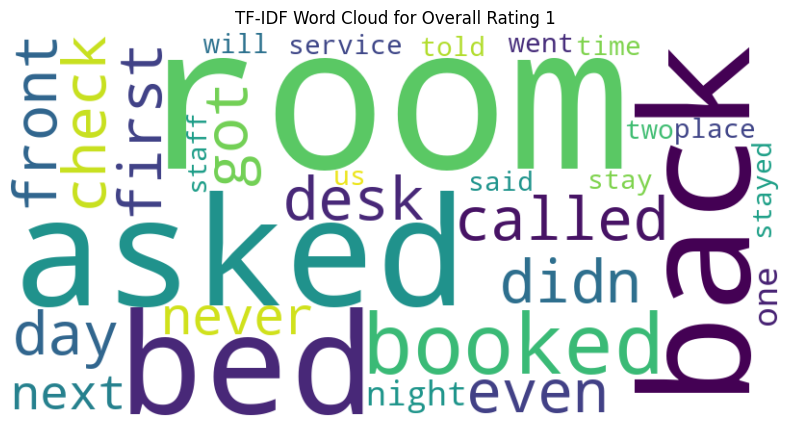

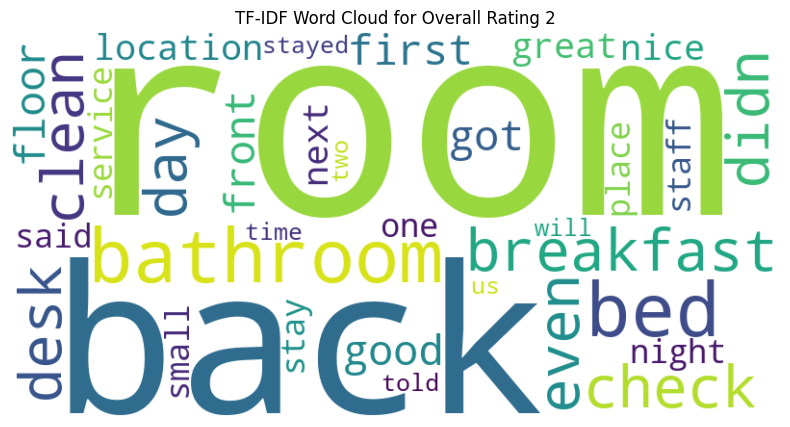

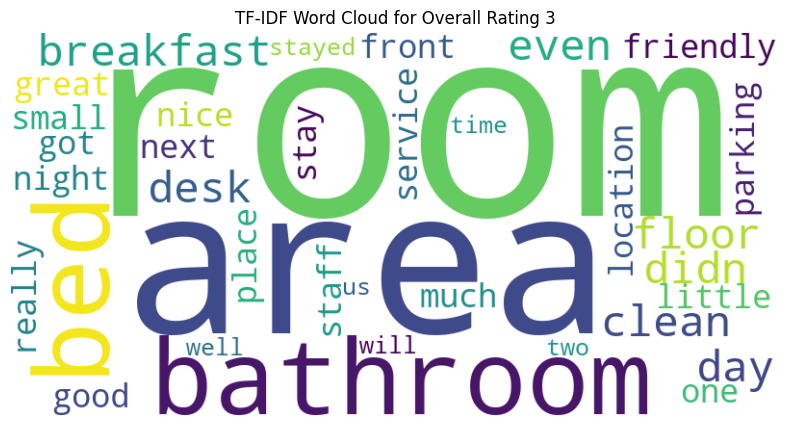

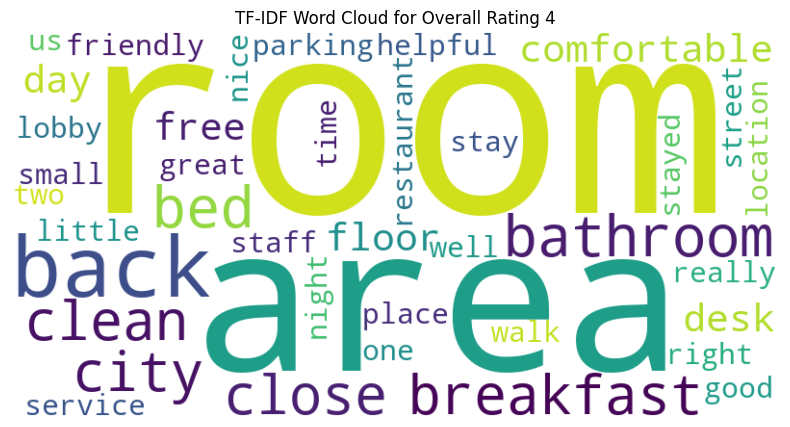

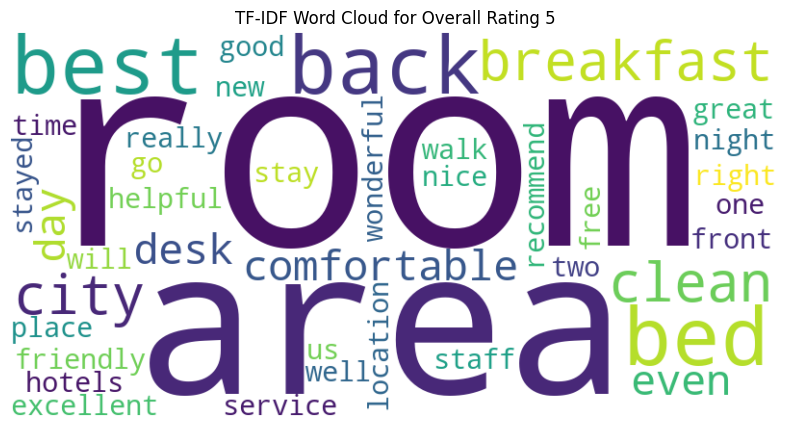

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


additional_stop_words = ['hotel', 'stay', 'would', 'could', 'even', 'one','stay','stayed','room','rooms']

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)
stop_words = set(stopwords.words('english') + additional_stop_words)

# ratings_overall 값에 따른 TF-IDF 기반 Word Cloud 생성 함수
def generate_tfidf_wordcloud_for_rating(rating, text_column):
    # 해당 rating에 해당하는 리뷰들 선택
    subset = df[df['ratings_overall'] == rating]
    
    # 해당 리뷰들의 text 컬럼을 합치기
    documents = subset[text_column].astype(str).tolist()
    
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(stop_words=custom_stop_words, max_features=100)
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # 각 단어와 그에 대한 TF-IDF 값을 딕셔너리로 저장
    feature_names = vectorizer.get_feature_names_out()
    tfidf_dict = dict(zip(feature_names, vectorizer.idf_))
    
    # Word Cloud에 표시할 중요한 단어들 선택
    important_words = [word for word, tfidf in tfidf_dict.items() if tfidf < 5.0]
    
    # Word Cloud 생성
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(important_words))
    
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Word Cloud for Overall Rating {rating}')
    plt.show()

# ratings_overall 값에 따라 TF-IDF Word Cloud 생성
for rating in range(1, 6):
    generate_tfidf_wordcloud_for_rating(rating, 'text')


#TODO : tf-idf 어떻게 되는건지 좀 더 살펴보기 


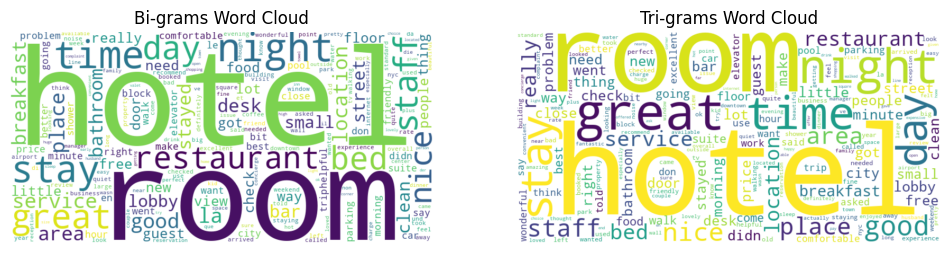

In [200]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

subset = df[df['ratings_overall'] == 1]
    
documents = subset['text'].astype(str).tolist()

# Bi-grams 설정
bi_gram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bi_gram_matrix = bi_gram_vectorizer.fit_transform(df['text'])

# Tri-grams 설정
tri_gram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
tri_gram_matrix = tri_gram_vectorizer.fit_transform(df['text'])

# Bi-grams와 Tri-grams의 feature names 확인
bi_gram_feature_names = bi_gram_vectorizer.get_feature_names_out()
tri_gram_feature_names = tri_gram_vectorizer.get_feature_names_out()

# Bi-grams와 Tri-grams 시각화
bi_gram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(bi_gram_feature_names))
tri_gram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tri_gram_feature_names))

# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bi_gram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bi-grams Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(tri_gram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tri-grams Word Cloud')

plt.show()


#TODO : bigram, tigram인데 왜 단어가 하나씩 나오는지 살펴보기 


# 날짜 데이터 시각화하기

In [161]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])
df

ratings  \
0     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2     {'service': 2.0, 'cleanliness': 3.0, 'overall'...   
3     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
4     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
...                                                 ...   
8781  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
8782  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8783  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8784                                   {'overall': 5.0}   
8785  {'service': 1.0, 'cleanliness': 1.0, 'overall'...   

                                                  title  \
0     “Very nice experience for a country boy going ...   
1                                     “Great Courtyard”   
2                       “Location, location, location!”   
3     “This place is run down, not taken care of at ...   
4                     “The good, the bad and the ugly.”   
...                                                 ...   
8781                                “Fantastic Service”   
8782   “If you get the good rooms, the view is awesome”   
8783   “Super Hotel in New York - Real value for money”   
8784                          “Ultimate New York Hotel”   
8785                                            “AWFUL”   

                                                   text  \
0     Being from a small town in Tennessee, I was ve...   
1     I stayed at this courtyard for 2 nights . Ever...   
2     Even in Boston for $180 plus taxes per night y...   
3     This hotel is a great old building (formerly t...   
4     The Good~room was larger than expected, free i...   
...                                                 ...   
8781  We stayed at the Grand del Mar because my husb...   
8782  Firstly, I find that San Francisco hotels gene...   
8783  Rooms very clean and big for new york standard...   
8784  My wife and I spent an anniversary here last O...   
8785  Rooms dirty and small. No customer service. In...   

                                                 author     date_stayed  \
0     {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1     {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2     {'username': 'marknthedark', 'num_cities': 17,...  September 2007   
3     {'username': 'Largeandy', 'num_cities': 16, 'n...   February 2012   
4     {'username': 'bigdog717', 'num_cities': 2, 'nu...       July 2010   
...                                                 ...             ...   
8781  {'username': 'Ontario_Sun_lovers', 'num_cities...       June 2010   
8782  {'username': 'mark_mb', 'num_cities': 21, 'num...        May 2010   
8783  {'username': 'DenmarkTraveler', 'num_reviews':...   December 2009   
8784  {'username': 'Steven_Goldberg', 'num_reviews':...    October 2006   
8785  {'username': 'carengur', 'num_reviews': 1, 'id...      April 2009   

      offering_id  num_helpful_votes       date         id  via_mobile  ...  \
0          111492                  2 2010-10-25   84800976       False  ...   
1          108562                  0 2009-10-14   46861760       False  ...   
2           94354                  1 2007-10-20   10172355       False  ...   
3           98798                  2 2012-02-09  124329781       False  ...   
4           93889                  0 2010-07-06   69904714       False  ...   
...           ...                ...        ...        ...         ...  ...   
8781       781627                  0 2010-06-22   68326910       False  ...   
8782        81295                  1 2010-10-23   84568810       False  ...   
8783      1060157                  0 2010-02-09   55572710       False  ...   
8784       224224                  7 2007-09-11    8693338       False  ...   
8785        99288                  0 2009-08-08   37094987       False  ...   

      ratings_cleanliness  ratings_overall  ratings_value  ratings_loca

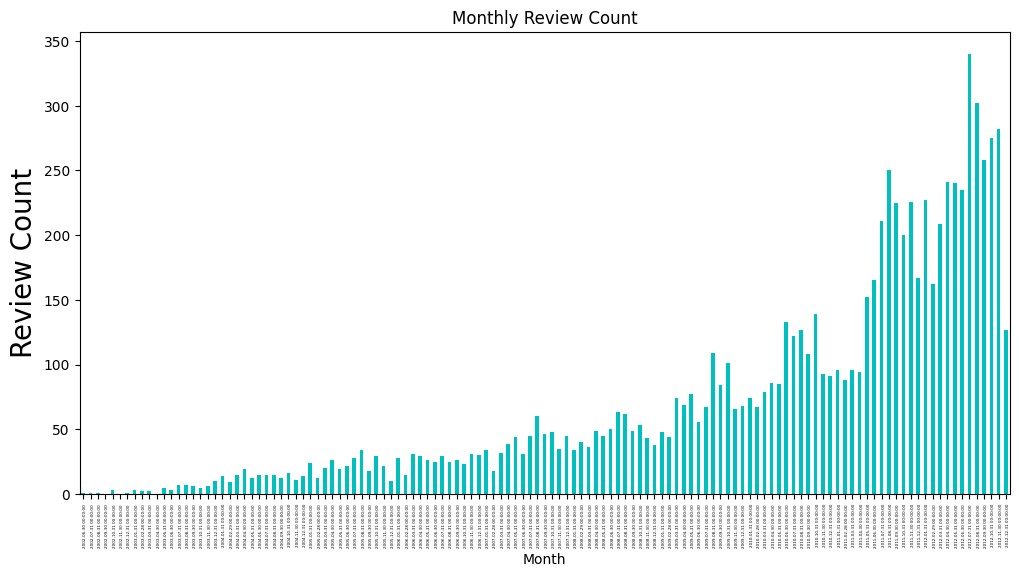

In [174]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 날짜를 기반으로 월별 리뷰 수 계산
monthly_review_count = df.resample('M', on='date').size()

# 월별 리뷰 수 시각화
plt.figure(figsize=(12, 6))
monthly_review_count.plot(kind='bar', color='c')
plt.title('Monthly Review Count')
plt.xlabel('Month',fontsize=10)
plt.ylabel('Review Count',fontsize=20)
plt.xticks(rotation_mode='anchor', ha='right',fontsize=3)
plt.show()


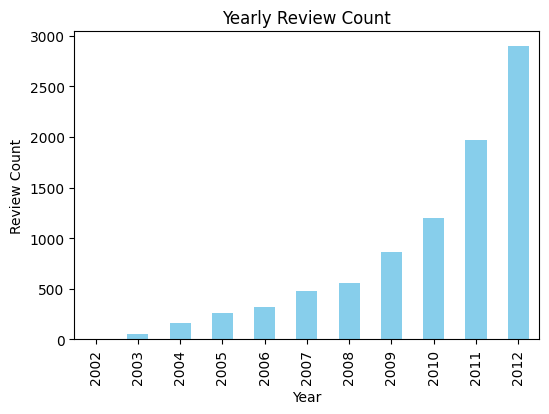

In [176]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 연도별 리뷰 수 계산
df['year'] = df['date'].dt.year
yearly_review_count = df['year'].value_counts().sort_index()

# 연도별 리뷰 수 시각화
plt.figure(figsize=(6, 4))
yearly_review_count.plot(kind='bar', color='skyblue')
plt.title('Yearly Review Count')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.show()


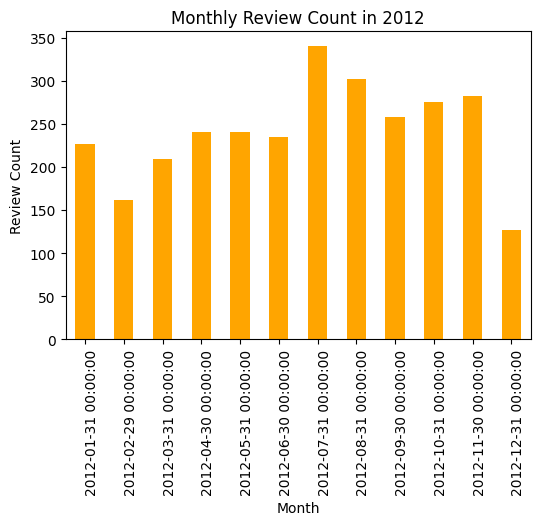

In [178]:
# 2012년도의 리뷰 추이 시각화
reviews_2012 = df[df['year'] == 2012]
monthly_review_count_2012 = reviews_2012.resample('M', on='date').size()

plt.figure(figsize=(6, 4))
monthly_review_count_2012.plot(kind='bar', color='orange')
plt.title('Monthly Review Count in 2012')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation_mode='anchor', ha='right')
plt.show()


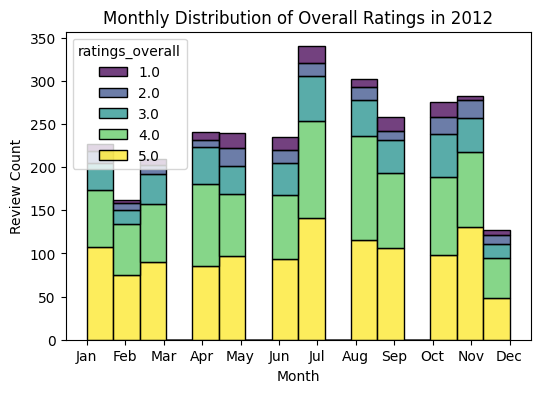

In [184]:
import seaborn as sns

# 2012년도의 리뷰 추이 시각화 (누적 바 그래프)
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=reviews_2012, x=reviews_2012['date'].dt.month, hue='ratings_overall', multiple='stack', palette='viridis', stat='count', common_norm=False)
plt.title('Monthly Distribution of Overall Ratings in 2012')
plt.xlabel('Month')
plt.ylabel('Review Count')

# xticks 모두 표시
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()


# author 분석하기

In [204]:
type(df['author'].iloc[0])

str

In [210]:
import json
from pandas import json_normalize

def parse_json(x):
    try:
        return json.loads(x.replace("'", "\"")) if isinstance(x, str) else x
    except json.JSONDecodeError:
        # JSON 형식이 아닌 경우 예외 처리
        return None

# author 컬럼에 대해 JSON 파싱 수행
df['author'] = df['author'].apply(parse_json)

# JSON 파싱이 실패한 경우 해당 행 삭제
df = df.dropna(subset=['author'])

# json_normalize를 통해 하나의 JSON을 각 컬럼으로 펼치기
normalized_author = json_normalize(df['author']).fillna(0)

# 새로 만든 normalized_author의 칼럼들 이름을 'author_'로 바꿔주기
normalized_author.columns = ['author_' + col for col in normalized_author.columns]

# 결과 확인
print(normalized_author)


         author_username  author_num_reviews  \
0              Tucker124                 1.0   
1              bimbotrip                 1.0   
2           marknthedark                20.0   
3              Largeandy                32.0   
4              bigdog717                 2.0   
...                  ...                 ...   
8768  Ontario_Sun_lovers                28.0   
8769             mark_mb                23.0   
8770     DenmarkTraveler                 1.0   
8771     Steven_Goldberg                 1.0   
8772            carengur                 1.0   

                             author_id      author_location  \
0     39AA7B174D045F1E2BAE8A398D00BBC2    Martin, Tennessee   
1     88E51140F05E96098AB1F8CF3976B691               Mexico   
2     F59724E77C3653E0FADF38D34EDCB122        Bangor, Maine   
3     74BE69EB45669EDA448297E922E7160D              Ruidoso   
4     22703108484AF7F632C053172E5B9E1C   Bayville, New York   
...                                ...       

In [211]:
df.shape

(8773, 22)

In [213]:
# df의 인덱스를 행 번호로 통일
df.reset_index(inplace=True, drop=True)

# normalized_ratings의 인덱스를 행 번호로 통일
normalized_author.reset_index(inplace=True, drop=True)

print("df의 인덱스:", df.index)
print("normalized_ratings의 인덱스:", normalized_ratings.index)

df의 인덱스: RangeIndex(start=0, stop=8773, step=1)
normalized_ratings의 인덱스: RangeIndex(start=0, stop=8786, step=1)


In [214]:
df = pd.concat([df, normalized_author], axis=1)
df.head(3)

ratings  \
0  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2  {'service': 2.0, 'cleanliness': 3.0, 'overall'...   

                                               title  \
0  “Very nice experience for a country boy going ...   
1                                  “Great Courtyard”   
2                    “Location, location, location!”   

                                                text  \
0  Being from a small town in Tennessee, I was ve...   
1  I stayed at this courtyard for 2 nights . Ever...   
2  Even in Boston for $180 plus taxes per night y...   

                                              author     date_stayed  \
0  {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1  {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2  {'username': 'marknthedark', 'num_cities': 17,...  September 2007   

   offering_id  num_helpful_votes       date        id  via_mobile  ...  \
0       111492                  2 2010-10-25  84800976       False  ...   
1       108562                  0 2009-10-14  46861760       False  ...   
2        94354                  1 2007-10-20  10172355       False  ...   

   text_length  language  year  author_username  author_num_reviews  \
0          905        en  2010        Tucker124                 1.0   
1          184        en  2009        bimbotrip                 1.0   
2          570        en  2007     marknthedark                20.0   

                          author_id    author_location  \
0  39AA7B174D045F1E2BAE8A398D00BBC2  Martin, Tennessee   
1  88E51140F05E96098AB1F8CF3976B691             Mexico   
2  F59724E77C3653E0FADF38D34EDCB122      Bangor, Maine   

   author_num_helpful_votes  author_num_cities  author_num_type_reviews  
0                       2.0                0.0                      0.0  
1                       0.0                0.0                      0.0  
2                      19.0               17.0                     20.0  

[3 rows x 29 columns]

In [215]:
df['author_location']

0         Martin, Tennessee
1                    Mexico
2             Bangor, Maine
3                   Ruidoso
4        Bayville, New York
               ...         
8768       Waterloo, Canada
8769        Manhattan Beach
8770                Denmark
8771    Marlton, New Jersey
8772                    NYC
Name: author_location, Length: 8773, dtype: object

In [216]:
import pandas as pd
import re
from collections import Counter


# 국가 또는 도시 추출하는 함수
def extract_location(location):
    match = re.search(r'\b(\w+),? \w*\b', location)
    return match.group(1) if match else None

# "author_location"에서 국가 또는 도시 정보 추출
df['extracted_location'] = df['author_location'].apply(extract_location)

# 추출된 국가 또는 도시의 빈도 분석
location_counts = Counter(df['extracted_location'].dropna())

# 결과 출력
print("Extracted Locations and Their Frequencies:")
for location, count in location_counts.items():
    print(f"{location}: {count} times")


Extracted Locations and Their Frequencies:
Martin: 1 times
Bangor: 4 times
Bayville: 2 times
London: 97 times
South: 30 times
Bakersfield: 3 times
Charlotte: 20 times
Columbia: 8 times
West: 28 times
New: 230 times
chatham: 1 times
Richmond: 15 times
Halton: 1 times
Isle: 2 times
Toulon: 1 times
Denver: 35 times
Athens: 4 times
Sydney: 36 times
Toronto: 60 times
Darien: 1 times
Frisco: 5 times
ATLANTA: 1 times
Greensboro: 8 times
Floyds: 1 times
Chapel: 4 times
mechanicsville: 1 times
Campo: 1 times
Los: 117 times
Tamworth: 1 times
Boston: 73 times
Seville: 2 times
Palm: 11 times
Glenside: 1 times
San: 210 times
Washington: 109 times
Tokyo: 17 times
Atlanta: 49 times
Lahore: 1 times
Dallas: 70 times
Westbrook: 1 times
Tallahassee: 3 times
Rehoboth: 2 times
st: 4 times
Dover: 2 times
long: 4 times
Karlsruhe: 3 times
Chula: 1 times
Vienna: 6 times
Tulsa: 7 times
Austin: 54 times
Minneapolis: 33 times
Vancouver: 41 times
Santa: 29 times
Minooka: 2 times
Seattle: 34 times
Silver: 5 times
C

In [89]:
import pandas as pd

# Assuming df is your DataFrame
df.to_csv("eda_ver_dataset.csv", index=False)
